# Read in Data

In [23]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import scipy.stats as scp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import itertools
from scipy.signal import hilbert
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import scipy.signal as scs
import json
import pickle
import plotly.graph_objects as go
from itertools import combinations
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

sns.set(context='talk', style='white', font='Arial')

today = date.today().strftime('%Y%m%d')

project_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/'
data_dir = project_dir + 'proc/group/parcel_timeseries/sub_ts/'

big_data_dir = '/Users/catcamacho/Documents/bigdata/hbn_clin/'

sample_file = project_dir + 'proc/group/datasets_info/sample_gord.32k_fs_LR.pscalar.nii'
atlas_file = project_dir + 'proc/null_lL_WG33/Gordon333_SeitzmanSubcortical.32k_fs_LR.dlabel.nii'

ax0 = nib.load(sample_file).header.get_axis(0)
ax1 = nib.load(sample_file).header.get_axis(1)

TR = 0.8

# get network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

# load subject info
subinfo = pd.read_csv(project_dir + 'proc/group/datasets/firstleveldatalabels_withpub_thresh0.8_20220412.csv', index_col=0)
subinfo = subinfo.drop(['set','sub','cond'], axis=1)
subinfo = subinfo.drop_duplicates()
subinfo.index.name='sub'

# assign developmental groups
subinfo['age_group'] = 'younger'
subinfo.loc[(subinfo['age']>10), 'age_group'] = 'older'

# load clinical data
scaredsr = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SCARED_SR_20210322.csv'), 
                       index_col='EID', skiprows=[1]).loc[:,['SCARED_SR_SC','SCARED_SR_GD']]
scaredsr.index = ['sub-{0}'.format(a) for a in scaredsr.index]
scaredsr.index.name = 'sub'

scaredpr = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SCARED_P_20210322.csv'), 
                       index_col='EID', skiprows=[1]).loc[:,['SCARED_P_SC','SCARED_P_GD']]
scaredpr.index = ['sub-{0}'.format(a) for a in scaredpr.index]
scaredpr.index.name = 'sub'

mfqsr = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_MFQ_SR_20210322.csv'), index_col='EID', skiprows=[1]).loc[:,'MFQ_SR_Total']
mfqsr.index = ['sub-{0}'.format(a) for a in mfqsr.index]
mfqsr.index.name = 'sub'

mfqpr = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_MFQ_P_20210322.csv'), index_col='EID', skiprows=[1]).loc[:,'MFQ_P_Total']
mfqpr.index = ['sub-{0}'.format(a) for a in mfqpr.index]
mfqpr.index.name = 'sub'

adhd = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SWAN_20210322.csv'), index_col='EID', skiprows=[1]).loc[:,'SWAN_Avg']
adhd.index = ['sub-{0}'.format(a) for a in adhd.index]
adhd.index.name = 'sub'

clincols = ['DX_{0}_Cat'.format(str(a).zfill(2)) for a in range(1,10)] + ['DX_{0}_Sub'.format(str(a).zfill(2)) for a in range(1,10)]
clindx = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_ConsensusDx_20210322_nodupes.csv'), index_col=0).loc[:,clincols]
clindx = clindx.fillna('none')
clindx['combined_dx'] = clindx.loc[:, clincols].agg(lambda x: ','.join(x.values), axis=1)
clindx.index = ['sub-{0}'.format(a) for a in clindx.index]
clindx.index.name = 'sub'

subinfo = subinfo.merge(adhd, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(mfqsr, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(mfqpr, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(scaredsr, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(scaredpr, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(clindx.loc[:, 'combined_dx'], how='left', left_index=True, right_index=True)
subinfo = subinfo.drop_duplicates()

# drop anyone missing clinical symptom data
subinfo = subinfo.loc[(np.isfinite(subinfo['SCARED_SR_SC']) | np.isfinite(subinfo['SCARED_P_SC'])), :]
subinfo.head()

,movie,age,site,female,meanFD,righthanded,PPS_score,age_group,SWAN_Avg,MFQ_SR_Total,MFQ_P_Total,SCARED_SR_SC,SCARED_SR_GD,SCARED_P_SC,SCARED_P_GD,combined_dx
sub,,,,,,,,,,,,,,,,
sub-NDARAA504CRN,TP,9.165297,cbic,1,0.480957,1,NaN,younger,0.388888,18.0,3.0,2.0,7.0,1.0,8.0,"Neurodevelopmental Disorders,Neurodevelopmenta..."
sub-NDARAA504CRN,DM,9.165297,cbic,1,0.599214,1,NaN,younger,0.388888,18.0,3.0,2.0,7.0,1.0,8.0,"Neurodevelopmental Disorders,Neurodevelopmenta..."
sub-NDARAA948VFH,TP,7.982660,rubic,1,0.102532,1,6.0,younger,0.500000,16.0,2.0,11.0,0.0,1.0,1.0,"Neurodevelopmental Disorders,Elimination Disor..."
sub-NDARAA948VFH,DM,7.982660,rubic,1,0.107775,1,6.0,younger,0.500000,16.0,2.0,11.0,0.0,1.0,1.0,"Neurodevelopmental Disorders,Elimination Disor..."
sub-NDARAB348EWR,TP,5.805384,cbic,0,0.372852,1,5.0,younger,0.222222,NaN,8.0,NaN,NaN,0.0,0.0,"Depressive Disorders,Depressive Disorders,Neur..."


In [16]:
subinfo.columns

Index(['movie', 'age', 'site', 'female', 'meanFD', 'righthanded', 'PPS_score',
       'age_group', 'SWAN_Avg', 'MFQ_SR_Total', 'MFQ_P_Total', 'SCARED_SR_SC',
       'SCARED_SR_GD', 'SCARED_P_SC', 'SCARED_P_GD', 'combined_dx'],
      dtype='object')

# set up functions

In [3]:
def compile_ts_data(subdf, movie, datadir, outfile):
    """
    combine data for each movie together into 1 file
    
    Parameters
    ----------
    subdf: DataFrame
        A dataframe with subject IDs as the index. Includes IDs for all usable data.
    movie: str
        Corresponds with the str for the movie content to concatenate (e.g., "DM" or "TP").
    datadir: folder path
        Path to folder with the subject timeseries ciftis.
    outfile: file path
        Path including filename to save the output data of shape Ntimepoints x Nparcels x Nsubjects.
    
    Returns
    -------
    data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    """
    if not isinstance(subdf, pd.DataFrame):
        subdf = pd.read_csv(subdf, index_col=0)
    
    for sub in subdf.index:
        file = '{0}{1}_task-movie{2}_bold1_AP_Atlas_rescale_resid0.9_filt_gordonseitzman.32k_fs_LR.ptseries.nii'.format(datadir,sub, movie)
        if sub == subdf.index[0]:
            data = StandardScaler().fit_transform(nib.load(file).get_fdata())
            data = np.expand_dims(data, axis=2)
        else:
            t = StandardScaler().fit_transform(nib.load(file).get_fdata())
            t = np.expand_dims(t, axis=2)
            data = np.concatenate([data,t],axis=2)
    
    print('Compile data from {0} brain regions measured at {1} timepoints from {2} participants.'.format(data.shape[1],data.shape[0],data.shape[2]))
    np.save(outfile, data)
    return(data)


def compute_group_phase(group_ts_data, outfile):
    """
    convert parcel ts to standard units & compute phase angles for each parcel ts
    
    Parameters
    ----------
    group_ts_data: filepath OR numpy array
        File or numpy array with compiled timeseries data of shape Ntimepoints x Nparcels x Nsubjects 
    
    Returns
    -------
    group_phase_data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    """
    
    if not isinstance(group_ts_data, np.ndarray):
        group_ts_data = np.load(group_ts_data)
    
    group_phase_data = np.zeros_like(group_ts_data)
    
    for a in range(0,group_ts_data.shape[1]):
        for b in range(0,group_ts_data.shape[2]):
            group_phase_data[:,a,b] = np.angle(hilbert(group_ts_data[:,a,b]), deg=False)
    
    np.save(outfile, group_phase_data)
    
    return(group_phase_data)

In [4]:
def compute_isps(group_phase_data, outprefix, savemean=True, small=False):
    """
    parcel-wise inter-subject phase synchrony- output pairwise IPS and mean global IPS
    
    Parameters
    ----------
    group_phase_data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
        
    Returns
    -------
    isps_data: numpy array
        intersubject phase synchrony data of shape Nparcels x Nsubjects x Nsubjects x Ntimepoints
    mean_isps_data: numpy array
        intersubject phase synchrony data, averaged across time, of shape Nparcels x Nsubjects x Nsubjects
        
    """
    if not isinstance(group_phase_data, np.ndarray):
        group_phase_data = np.load(group_phase_data)
    
    if os.path.isdir(outprefix):
        file_name = os.path.join(outprefix, 'isps_data.dat')
    else:
        file_name = outprefix + 'isps_data.dat'
        
    if not small:
        isps_data = np.memmap(file_name, dtype=np.float32, mode='w+',
                              shape=(group_phase_data.shape[1],group_phase_data.shape[2],
                                     group_phase_data.shape[2],
                                     group_phase_data.shape[0]))
    else:
        isps_data = np.empty((group_phase_data.shape[1],group_phase_data.shape[2],
                              group_phase_data.shape[2],group_phase_data.shape[0]))
    
    subs = range(0, group_phase_data.shape[2])
    for region in range(0, group_phase_data.shape[1]):
        combs = itertools.combinations(subs, 2)
        for c in combs:
            sub1 = group_phase_data[:, region, c[0]]
            sub2 = group_phase_data[:, region, c[1]]
            a = 1 - np.sin(np.abs(sub1 - sub2) / 2)
            isps_data[region,c[0],c[1],:] = a
            isps_data[region,c[1],c[0],:] = a
        
    if small:
        np.save(file_name, isps_data)
    if savemean:
        mask = np.tri(isps_data.shape[2], isps_data.shape[2], -1, dtype=int)
        mean_isps_data = np.mean(isps_data[:,mask==1,:], axis=1)
        if os.path.isdir(outprefix):
            mean_file_name = os.path.join(outprefix, 'mean_isps_data.npy')
        else:
            mean_file_name = outprefix + 'mean_isps_data.npy'
        
        np.save(mean_file_name, mean_isps_data.T)
    
        return(mean_isps_data, isps_data)
    else:
        return(isps_data)


def intersubject_timeseries_correlation(data, outprefix, ax0=ax0, ax1=ax1):
    """
    Parameters
    ----------
    data: numpy array
        data in the shape of Ntimepoints x Nregions x Nsubjects
    outprefix: str
        name to save ISC data to
    
    Returns
    -------
    intersub_isc: numpy array
        intersubject spearman correlations in the shape of Nregions x Nsubjects x Nsubjects
    group_isc: numpy array
        group mean spearman correlations in the shape of Nregions
    """
    subs = range(0,data.shape[2])
    
    intersub_isc = np.zeros((data.shape[1],data.shape[2],data.shape[2]))
    group_isc = np.zeros((data.shape[1]))
    mask = np.tri(data.shape[2], data.shape[2], -1, dtype=int)
    
    for r in range(0, data.shape[1]):
        intersub_isc[r, :, :]= np.corrcoef(data[:, r, :], rowvar=False)
            
    for r in range(0, data.shape[1]):
        group_isc[r] = np.mean(intersub_isc[r,:,:][mask==1])
    
    np.save(outprefix + 'intersub_timeseries_ISC.npy', intersub_isc)
    img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(group_isc, axis=0), (ax0, ax1))
    nib.save(img, outprefix + 'mean_timseries_ISC.pscalar.nii')
    
    return(intersub_isc, group_isc)


def intersubject_distance(data, outfile_prefix):
    """
    Compute static pairwise intersubject similarity
    
    Parameters
    ----------
    data: numpy array
        1D array of subject data (i.e., each participant contributes exactly 1 measure)
    outfilename: str
        name to save distance data to
    
    Returns
    -------
    isdistances: numpy array
        intersubject distances in the shape of Nsubjects x Nsubjects x Nmetrics
    """
    subs = range(0,data.shape[0])


    # NN
    nn = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        nn[c[0],c[1]] = np.max(data) - abs(data[c[0]] - data[c[1]])
        nn[c[1],c[0]] = np.max(data) - abs(data[c[0]] - data[c[1]])
    np.save(outfile_prefix + '_NN.npy', nn)

    # AnnaK mean
    annakmean = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        annakmean[c[0],c[1]] = (data[c[0]] + data[c[1]]) / 2
        annakmean[c[1],c[0]] = (data[c[0]] + data[c[1]]) / 2
    np.save(outfile_prefix + '_annakmean.npy', annakmean)
    
    # AnnaK max min mean
    AnnaKmaxminmean = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        AnnaKmaxminmean[c[0],c[1]] = np.max(data) - ((data[c[0]] + data[c[1]]) / 2)
        AnnaKmaxminmean[c[1],c[0]] = np.max(data) - ((data[c[0]] + data[c[1]]) / 2)
    np.save(outfile_prefix + '_annakmaxminmean.npy', AnnaKmaxminmean)

    # AnnaK min
    annakmin = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        annakmin[c[0],c[1]] = min([data[c[0]],data[c[1]]])
        annakmin[c[1],c[0]] = min([data[c[0]],data[c[1]]])
    np.save(outfile_prefix + '_annakmin.npy', annakmin)

    # AnnaK max minus min
    annakmaxminmax = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        annakmaxminmax[c[0],c[1]] =np.max(data) -  max([data[c[0]],data[c[1]]])
        annakmaxminmax[c[1],c[0]] = np.max(data) - max([data[c[0]],data[c[1]]])
    np.save(outfile_prefix + '_annakmaxminmax.npy', annakmaxminmax)
        
    # AnnaK absmean
    annakabsmean = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        annakabsmean[c[0],c[1]] = abs(data[c[0]] - data[c[1]]) * ((data[c[0]] + data[c[1]]) / 2)
        annakabsmean[c[1],c[0]] = abs(data[c[0]] - data[c[1]]) * ((data[c[0]] + data[c[1]]) / 2)
    np.save(outfile_prefix + '_annakabsmean.npy', annakabsmean)
    
    isdistances = {'NN': nn, 
                   'AnnaKmean': annakmean, 
                   'AnnaKmin': annakmin, 
                   'AnnaKabsmean': annakabsmean, 
                   'AnnaKmaxminmean': AnnaKmaxminmean, 
                   'AnnaKmaxminmax': annakmaxminmax}
    return(isdistances)

In [5]:
def static_brain_bx_isrsa(brain_sim_data, bx_sim_data, outfilename=None):
    """
    
    Parameters
    ----------
    brain_sim_data: numpy ndarray
        Data in the shape of Nsubjects x Nsubjects
    bx_sim_data: numpy ndarray
        Data in the shape of Nsubjects x Nsubjects
        
    Returns
    -------
    rsa_report: pandas DataFrame
        Pandas DataFrame with inter-subject representational similarity statistics
    """
    rsa_report = pd.DataFrame(columns=['SpearR','SpearPvalue'])
    
    mask = np.tri(bx_sim_data.shape[0], bx_sim_data.shape[0], -1, dtype=int)
    bx_sim = bx_sim_data[mask==1]
    brain_sim = brain_sim_data[mask==1]
    
    r, p = scp.spearmanr(bx_sim, brain_sim)
    rsa_report.loc[0,'SpearR'] = r
    rsa_report.loc[0,'SpearPvalue'] = p
    if outfilename:
        sns.scatterplot(bx_sim, brain_sim)
        plt.title('Similarity Correlation')
        plt.tight_layout()
        plt.savefig(outfilename)
        plt.show()
        plt.close()
    
    return(rsa_report)

def regional_perm_bx_isrsa(regional_sim_data, bx_sim_data, outprefix, alpha=0.05, n_perms=1000, ax0=ax0, ax1=ax1):
    """
    
    Parameters
    ----------
    regional_sim_data: numpy ndarray
        Data in the shape of Nregions x Nsubjects x Nsubjects
    bx_sim_data: numpy ndarray
        Data in the shape of Nsubjects x Nsubjects
        
    Returns
    -------
    region_isrsa: numpy ndarray
        Data in the shape of Nregions
    """
    
    mask = np.tri(bx_sim_data.shape[1], bx_sim_data.shape[1], -1, dtype=int)

    # flatten behavior lower triangle
    bx_sim = bx_sim_data[mask==1]

    region_isrsa = np.zeros((regional_sim_data.shape[0]))

    for region in range(0, regional_sim_data.shape[0]):
            brain_sim = regional_sim_data[region,:,:][mask==1]
            r, p = scp.spearmanr(bx_sim, brain_sim)
            region_isrsa[region] = r

    shuff_bx = bx_sim
    perm_isrsa_null = np.zeros((n_perms, regional_sim_data.shape[0]))

    # make null distributions for each TR and region
    for a in range(0,n_perms):
        np.random.shuffle(shuff_bx)
        for region in range(0,regional_sim_data.shape[0]):
            brain_sim = regional_sim_data[region,:,:][mask==1]
            r, p = scp.spearmanr(shuff_bx, brain_sim)
            perm_isrsa_null[a, region] = r

    # compute permuted P threshold per region/TR
    raw_pvals = np.zeros(region_isrsa.shape)
    flat_null = perm_isrsa_null.flatten()
    for i, a in enumerate(region_isrsa):
        raw_pvals[i] = (np.sum((flat_null>=a).astype(int)) + 1) / (flat_null.shape[0] + 1)
        
    # save ciftis with raw values
    img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(raw_pvals, axis=0), (ax0, ax1))
    nib.save(img, outprefix + '_permsim_raw_pval.pscalar.nii')
    
    img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(region_isrsa, axis=0), (ax0, ax1))
    nib.save(img, outprefix + '_permsim_raw_rho.pscalar.nii')
    
    
    # save cifti with significant rhos only
    thresh_mask = raw_pvals<alpha

    # pvals
    thresh_pval = raw_pvals
    thresh_pval[thresh_mask==0] = np.nan
    img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(thresh_pval, axis=0), (ax0, ax1))
    nib.save(img, outprefix + '_permsim_masked_pval{0}.pscalar.nii'.format(alpha))

    # rhos
    thresh_isrsa = region_isrsa
    thresh_isrsa[thresh_mask==0] = np.nan
    thresh_isrsa[thresh_isrsa<0] = np.nan
    img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(thresh_isrsa, axis=0), (ax0, ax1))
    nib.save(img, outprefix + '_permsim_masked_rho{0}.pscalar.nii'.format(alpha))
    return(thresh_isrsa)


# compute dynamic similarity
def dynamic_brain_bx_isrsa(time_region_sim_data, bx_sim_data, outprefix, ax1=ax1):
    """
    
    Parameters
    ----------
    time_region_sim_data: numpy ndarray
        Data in the shape of Nregions x Nsubjects x Nsubjects x Ntimepoints
    bx_sim_data: numpy ndarray
        Data in the shape of Nsubjects x Nsubjects
        
    Returns
    -------
    dynamic_isrsa: pandas DataFrame
        Pandas DataFrame with inter-subject representational similarity statistics
    """
    mask = np.tri(bx_sim_data.shape[1], bx_sim_data.shape[1], -1, dtype=int)

    # flatten behavior lower triangle
    bx_sim = bx_sim_data[mask==1]

    dynamic_isrsa = np.zeros((isps_data.shape[3],isps_data.shape[0]))

    for region in range(0, isps_data.shape[0]):
        for tr in range(0, isps_data.shape[3]):
            brain_sim = isps_data[region,:,:,tr][mask==1]
            r, p = scp.spearmanr(bx_sim, brain_sim)
            dynamic_isrsa[tr, region] = r
            
    np.save(outfile_prefix + '_dynamicsim.npy', dynamic_isrsa)
    
    ax0 = nib.cifti2.cifti2_axes.SeriesAxis(0,0.8,dynamic_isrsa.shape[0], unit='second')
    img = nib.cifti2.cifti2.Cifti2Image(dynamic_isrsa, (ax0, ax1))
    nib.save(img, outfile_prefix + '_dynamicsim.ptseries.nii')

    return(dynamic_isrsa)


def perm_sig_dynamic_isrsa(time_region_sim_data, bx_sim_data, outprefix, n_perms=30, ax1=ax1, alpha=0.05, TR=0.8):
    """
    
    
    """
    
    dynamic_isrsa = dynamic_brain_bx_isrsa(time_region_sim_data, bx_sim_data, outprefix)
    
    if os.path.isfile(os.path.join(outprefix + '_perm_isrsa_null.dat')):
        perm_isrsa_null = np.memmap(os.path.join(outprefix + '_perm_isrsa_null.dat'), dtype=np.float32, mode='r',
                                    shape=(n_perms, isps_data.shape[3], isps_data.shape[0]))
    else:
        perm_isrsa_null = np.memmap(os.path.join(outprefix + '_perm_isrsa_null.dat'), dtype=np.float32, mode='w+',
                                    shape=(n_perms, isps_data.shape[3], isps_data.shape[0]))
        shuff_bx = bx_sim_data

        # make null distributions for each TR and region
        for a in range(0,n_perms):
            np.random.shuffle(shuff_bx)
            perm_isrsa_null[a, :, :] = dynamic_brain_bx_isrsa(time_region_sim_data, shuff_bx, outprefix)
    
    # compute permuted P threshold per region/TR
    orig_shape = dynamic_isrsa.shape
    flat_dyn_isrsa = dynamic_isrsa.flatten()
    raw_pvals = np.zeros(flat_dyn_isrsa.shape)
    flat_null = perm_isrsa_null.flatten()
    for i, a in enumerate(flat_dyn_isrsa):
        raw_pvals[i] = (np.sum((flat_null>=a).astype(int)) + 1) / (flat_null.shape[0] + 1)

    raw_pvals = np.reshape(raw_pvals, orig_shape)
    
    # save cifti
    ax0 = nib.cifti2.cifti2_axes.SeriesAxis(0,TR,raw_pvals.shape[0], unit='second')
    img = nib.cifti2.cifti2.Cifti2Image(dynamic_isrsa, (ax0, ax1))
    nib.save(img, outprefix + '_permdynamicsim_raw_rho.ptseries.nii')
    img = nib.cifti2.cifti2.Cifti2Image(raw_pvals, (ax0, ax1))
    nib.save(img, outprefix + '_permdynamicsim_raw_pval.ptseries.nii')
    
    # save cifti with significant rhos only
    thresh_mask = raw_pvals<alpha

    # pvals
    thresh_pval = raw_pvals
    thresh_pval[thresh_mask==0] = np.nan
    img = nib.cifti2.cifti2.Cifti2Image(thresh_pval, (ax0, ax1))
    nib.save(img, outprefix + '_permdynamicsim_thresh_pval{0}.ptseries.nii'.format(alpha))
    # rhos
    thresh_isrsa = dynamic_isrsa
    thresh_isrsa[thresh_mask==0] = np.nan
    thresh_isrsa[thresh_isrsa<0] = np.nan
    img = nib.cifti2.cifti2.Cifti2Image(thresh_isrsa, (ax0, ax1))
    nib.save(img, outprefix + '_permdynamicsim_thresh_rho{0}.ptseries.nii'.format(alpha))

In [6]:
def region_isrsa_fdr(disc_rho, disc_pval, rep_rho, rep_pval, outprefix, alpha=0.05, bon_alpha=True,replace_zeros=True, ax0=ax0, ax1=ax1):
    """
    
    
    """
    
    disc_rho = nib.load(disc_rho).get_fdata()
    disc_pval = nib.load(disc_pval).get_fdata()
    rep_rho = nib.load(rep_rho).get_fdata()
    rep_pval = nib.load(rep_pval).get_fdata()
    
    if replace_zeros:
        disc_pval[disc_pval==0] = np.nan
        rep_pval[rep_pval==0] = np.nan
    
    if bon_alpha==True:
        bon_alpha = np.sqrt(alpha/disc_pval.shape[1])
    else:
        bon_alpha = alpha

    dmask = (disc_pval<bon_alpha).astype(int)
    rmask = (rep_pval<bon_alpha).astype(int)

    mask = np.zeros(dmask.shape)
    mask[(dmask==1) & (rmask==1)] = 1

    bonrho = np.empty(mask.shape)
    bonrho[mask==1] = np.add(disc_rho[mask==1],rep_rho[mask==1])/2
    bonrho[mask==0] = np.nan

    img = nib.cifti2.cifti2.Cifti2Image(bonrho, (ax0, ax1))
    nib.save(img, outprefix + '_maskedrho_fdr{0}.pscalar.nii'.format(round(bon_alpha,5)))
    
    
def dynamic_isrsa_fdr(disc_rho, rep_rho, discN, repN, video_dur, ratings_file, outprefix, TR=TR, alpha=0.05, parcel_labels=parcel_labels):
    
    # assign thresholds
    bon_alpha = np.sqrt(0.05/disc_rho.shape[1])
    discbonnmint = scp.t.ppf(1-bon_alpha, discN-1)
    discuncorrmint = scp.t.ppf(1-alpha, discN-1)
    repbonnmint = scp.t.ppf(1-bon_alpha, repN-1)
    repuncorrmint = scp.t.ppf(1-alpha, repN-1)

    # convert rho to t-stat
    disc_tstat = disc_rho/np.sqrt((1-disc_rho**2)/(discN-2))
    rep_tstat = rep_rho/np.sqrt((1-rep_rho**2)/(repN-2))

    # find sig ts that replicate
    disc_sigts =  (disc_tstat > discbonnmint).astype(int)
    rep_sigts =  (rep_tstat > repbonnmint).astype(int)

    sigts = np.zeros(disc_sigts.shape).astype(int)
    sigts[(disc_sigts==1) & (rep_sigts==1)] = 1
    if sigts.max()==0:
        print('No significant findings.')
    else:
        print('At least one region is significantly simliar.')
    
    # Plot and analysis replicating peaks
    times = np.arange(0, video_dur, TR)

    results = dict()

    ### Make plots ###
    for p, parcel in enumerate(parcel_labels):
        if np.max(sigts.T[p])==1:
            # set up figure
            fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True, sharey=True)
            # plot discovery
            dupeaks, duproperties = scs.find_peaks(disc_tstat.T[p], width=5, prominence=discuncorrmint)

            ax[0].plot(times, disc_tstat.T[p], color='k')
            for i_c, c in enumerate(duproperties['prominences']):
                ax[0].axvspan(duproperties['left_ips'][i_c]*TR, duproperties['right_ips'][i_c]*TR,
                            color='r', alpha=0.3)
            dcpeaks, dcproperties = scs.find_peaks(disc_tstat.T[p], width=5, prominence=discbonnmint)
            for i_c, c in enumerate(dcproperties['prominences']):
                ax[0].axvspan(dcproperties['left_ips'][i_c]*TR, dcproperties['right_ips'][i_c]*TR,
                            color='b', alpha=0.3)
            ax[0].set_xlim([0,video_dur])
            ax[0].set_title(parcel + ': Discovery', weight='bold')
            ax[0].set_ylabel('Similarity (t-stat)')

            # plot replication
            rupeaks, ruproperties = scs.find_peaks(rep_tstat.T[p], width=5, prominence=repuncorrmint)
            ax[1].plot(times, rep_tstat.T[p], color='k')
            for i_c, c in enumerate(ruproperties['prominences']):
                ax[1].axvspan(ruproperties['left_ips'][i_c]*TR, ruproperties['right_ips'][i_c]*TR,
                            color='r', alpha=0.3)
            rcpeaks, rcproperties = scs.find_peaks(rep_tstat.T[p], width=5, prominence=repbonnmint)
            for i_c, c in enumerate(rcproperties['prominences']):
                ax[1].axvspan(rcproperties['left_ips'][i_c]*TR, rcproperties['right_ips'][i_c]*TR,
                            color='b', alpha=0.3)
            ax[1].set_xlim([0,video_dur])
            ax[1].set_title(parcel + ': Replication', weight='bold')
            ax[1].set_ylabel('Similarity (t-stat)')
            ax[1].set_xlabel('Time (s)')
            plt.tight_layout()
            plt.savefig(outprefix + 'peak_similarity_{0}.svg'.format(parcel_labels[p]))
            plt.show()
            plt.close()

            # save results
            dcproperties = {k:v.tolist() for k,v in dcproperties.items()}
            duproperties = {k:v.tolist() for k,v in duproperties.items()}
            rcproperties = {k:v.tolist() for k,v in rcproperties.items()}
            ruproperties = {k:v.tolist() for k,v in ruproperties.items()}
            if (len(ruproperties['left_ips'])>0) & (len(duproperties['left_ips'])>0):
                results[parcel] = {'Discovery': {'corr': dcproperties, 'uncorr': duproperties}, 
                                   'Replication': {'corr': rcproperties, 'uncorr': ruproperties}}
            
            
    ### Characterize differences in ratings for high versus low similarity points in the video ###
    
    # load ratings and shift forward 6 TRs
    ratings = pd.read_csv(ratings_file, index_col=0)
    ratings = ratings.iloc[0:int(video_dur/TR),:]
    ratings.loc[:,ratings.columns] = MinMaxScaler().fit_transform(ratings.to_numpy())
    ratings.index = range(6,int(video_dur/TR)+6)
    ratings = pd.concat([ratings, pd.DataFrame(np.nan, index=np.arange(0,6,1), columns=ratings.columns)])
    ratings = ratings.sort_index()
    ratings = ratings.iloc[0:int(video_dur/TR),:]
    
    # characterize areas within and outside the peaks
    for parcel in results.keys():
        discmask = np.zeros(times.shape)
        for i, c in enumerate(results[parcel]['Discovery']['uncorr']['prominences']):
            start = round(results[parcel]['Discovery']['uncorr']['left_ips'][i])
            end = round(results[parcel]['Discovery']['uncorr']['right_ips'][i])
            discmask[start:end] = 1

        repmask = np.zeros(times.shape)
        for i, c in enumerate(results[parcel]['Replication']['uncorr']['prominences']):
            start = round(results[parcel]['Replication']['uncorr']['left_ips'][i])
            end = round(results[parcel]['Replication']['uncorr']['right_ips'][i])
            repmask[start:end] = 1

        tmask = np.zeros(times.shape).astype(int)
        tmask[(discmask==1) & (repmask==1)] = 1

        ratesigdiff = pd.Series(index=ratings.columns, name='sig', dtype=int)
        ratemeans = dict()
        ratestats = dict()
        if tmask.max()==1:
            for measure in ratings.columns:
                underpeak = ratings.loc[tmask==1, measure]
                outofpeak = ratings.loc[tmask==0, measure]
                underpeakmean = np.nanmean(underpeak)
                outofpeakmean = np.nanmean(outofpeak)
                rate_stat, rate_pval = scp.ttest_ind(underpeak, outofpeak, nan_policy='omit')
                ratestats[measure] = {'tstat': rate_stat, 'pval': rate_pval}
                ratesigdiff[measure] = rate_pval < alpha
                ratemeans[measure] = {'underpeak': underpeakmean, 'outofpeak': outofpeakmean}

            results[parcel]['RatingsAnalysis'] = {'MeanRatings': ratemeans, 
                                                  'Stats': ratestats}

            # plot the differences
            sigratingsnames = ratesigdiff[ratesigdiff==True].index.to_list()

            if len(sigratingsnames) < 4:
                ratings_withpeakinfo = ratings
                ratings_withpeakinfo['UnderPeak'] = tmask
                temp = pd.melt(ratings_withpeakinfo, id_vars='UnderPeak', value_vars=sigratingsnames, value_name='Level',var_name='Rating')
                plt.figure(figsize=(2+2*len(sigratingsnames),6))
                sns.barplot(x='Rating', y='Level', hue='UnderPeak', data=temp, palette=['#FFFFFF','#BCB1C2'] , linewidth=2, edgecolor='k')
                plt.tight_layout()
                plt.savefig(outprefix + 'peak_ratings_sigdiff_{0}.svg'.format(parcel))
                plt.show()
                plt.close()
            else:
                underpeak = ratings.loc[tmask==1, sigratingsnames].mean(axis=0).to_frame()
                underpeak.columns = ['mean']
                underpeak['width']=0.4
                underpeak['measure'] = underpeak.index
                outofpeak = ratings.loc[tmask==0, sigratingsnames].mean(axis=0).to_frame()
                outofpeak.columns = ['mean']
                outofpeak['width']=0.7
                outofpeak['measure'] = outofpeak.index

                fig = go.Figure()

                fig.add_trace(go.Barpolar(
                    r=outofpeak['mean'],
                    theta=outofpeak['measure'],
                    width=outofpeak['width'],
                    base=0,
                    name='OutOfPeak',
                    marker_color='#FFFFFF',
                    marker_line_color='black',
                    marker_line_width=2,
                    opacity=1,
                ))

                fig.add_trace(go.Barpolar(
                      r=underpeak['mean'],
                      theta=underpeak['measure'],
                    width=underpeak['width'],
                      name='UnderPeak',
                    base=0,
                    marker_color='#BAB3BF',
                    marker_line_color='black',
                    marker_line_width=2,
                    opacity=1,
                ))

                fig.update_layout(
                    template='plotly_white',
                  polar=dict(
                      angularaxis_tickfont_size = 14,
                    radialaxis=dict(
                      visible=True,
                      range=[0, 1]
                    )),
                  showlegend=False
                )

                fig.write_image(outprefix + 'polar_ratings_sigdiff_{0}.svg'.format(parcel))

        
    #save results
    with open(outprefix + 'full_results_corrp{0}_prom{1}_width{2}.json'.format(round(bon_alpha,3), round(discbonnmint,2), 5), 'w') as fp:
        json.dump(results, fp, indent=4)
    return(results)


def synchrony_discrep_fdr_netlevel(disc_mean_sim, disc_null, rep_mean_sim, outprefix, video_dur, alpha=0.05, 
                                   TR=TR, parcel_labels=parcel_labels, atlas_file=atlas_file):
    # assign thresholds
    bon_alpha = np.sqrt(0.05/disc_mean_sim.shape[1])

    n = int(round((len(disc_null)+1)*bon_alpha,0))
    discbonmin = disc_null[len(disc_null)-n]
    n = int(round((len(rep_null)+1)*bon_alpha,0))
    repbonmin = rep_null[len(rep_null)-n]
    if discbonmin < np.percentile(disc_mean_sim, 1-alpha):
        discbonmin = np.percentile(disc_mean_sim, 1-alpha)
        repbonmin = np.percentile(rep_mean_sim, 1-alpha)
    print("Disc sig threshold: {0}".format(discbonmin))
    print("Rep sig threshold: {0}".format(repbonmin))

    # find sig rs that replicate
    disc_sig = (disc_mean_sim > discbonmin).astype(int)
    rep_sig = (rep_mean_sim > repbonmin).astype(int)

    sigrs = np.zeros(disc_sig.shape).astype(int)
    sigrs[(disc_sig==1) & (rep_sig==1)] = 1
    
    # find parcels with at least 5 consecutive seconds of sig synchrony
    sig_parcels = np.zeros(sigrs.shape[1]).astype(int)
    sigrs_df = pd.DataFrame(sigrs, columns=parcel_labels)
    sigrs_df['time'] = range(0, len(sigrs_df))
    for i, a in enumerate(parcel_labels):
        sigrs_df['segment'] = (sigrs_df[a].diff(1) != 0).astype(int).cumsum()
        dur = pd.DataFrame({'dur': sigrs_df.groupby('segment').time.last() - sigrs_df.groupby('segment').time.first(),
                            'value': sigrs_df.groupby('segment')[a].mean()}).reset_index(drop=True)
        dur = dur.loc[dur['value']==1]
        if dur['dur'].max() > 6:
            sig_parcels[i] = 1

    # average synchrony within networks and plot
    masked_disc = disc_mean_sim
    masked_disc[:,sig_parcels==0]=np.nan
    disc_sync_df = pd.DataFrame(disc_mean_sim, columns=network_labels)
    disc_sync_df = disc_sync_df.groupby(by=network_labels, axis=1).mean().dropna(axis=1)

    masked_rep = rep_mean_sim
    masked_rep[:,sig_parcels==0]=np.nan
    rep_sync_df = pd.DataFrame(rep_mean_sim, columns=network_labels)
    rep_sync_df = rep_sync_df.groupby(by=network_labels, axis=1).mean().dropna(axis=1)

    # make figs for sig parcels sorted by network/region group
    color = (142/255, 50/255, 209/255, 1)

    ax1 = nib.load(atlas_file).header.get_axis(1)
    data = nib.load(atlas_file).get_fdata()
    ax0 = nib.load(atlas_file).header.get_axis(0)
    newmap=dict()
    newmap[0] = ax0[0][1][0]
    for net in disc_sync_df:
        parcels_keep = parcel_labels[(network_labels==net) & (sig_parcels==1)]
        for a in range(1,len(parcel_labels) +1):
            if parcel_labels[a-1] in parcels_keep:
                newmap[a] = (parcel_labels[a-1], color)
            else:
                newmap[a] = (parcel_labels[a-1], (1,1,1,0))
        ax0.label[0] = newmap
        img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
        nib.save(img, outprefix + 'sig_averaged_parcels_{0}.dlabel.nii'.format(net))
        
    # Plot and analysis replicating peaks
    times = np.arange(0, video_dur, TR)

    results = dict()

    ### Make plots ###
    for net in disc_sync_df.columns:
        fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True, sharey=True)
        # plot discovery
        ax[0].plot(times, disc_sync_df[net], color='k')
        dcpeaks, dcproperties = scs.find_peaks(disc_sync_df[net], width=5, height=discbonmin)
        for i_c, c in enumerate(dcproperties['prominences']):
            ax[0].axvspan(dcproperties['left_ips'][i_c]*TR, dcproperties['right_ips'][i_c]*TR,
                        color='#BAB3BF', alpha=0.9)
        ax[0].set_xlim([0,video_dur])
        ax[0].set_title(net + ': Discovery', weight='bold')
        ax[0].set_ylabel('Synchrony')

        # plot replication
        ax[1].plot(times, rep_sync_df[net], color='k')
        rcpeaks, rcproperties = scs.find_peaks(rep_sync_df[net], width=5, height=repbonmin)
        for i_c, c in enumerate(rcproperties['prominences']):
            ax[1].axvspan(rcproperties['left_ips'][i_c]*TR, rcproperties['right_ips'][i_c]*TR,
                        color='#BAB3BF', alpha=0.9)
        ax[1].set_xlim([0,video_dur])
        ax[1].set_title(net + ': Replication', weight='bold')
        ax[1].set_ylabel('Synchrony')
        ax[1].set_xlabel('Time (s)')
        plt.tight_layout()
        #plt.show()
        plt.savefig(outprefix + 'peak_similarity_{0}.svg'.format(net))
        plt.close()

        # save results
        dcproperties = {k:v.tolist() for k,v in dcproperties.items()}
        rcproperties = {k:v.tolist() for k,v in rcproperties.items()}
        if (len(rcproperties['left_ips'])>0) & (len(dcproperties['left_ips'])>0):
            results[net] = {'Discovery': {'corr': dcproperties},
                               'Replication': {'corr': rcproperties}}


    ### Characterize differences in ratings for high versus low similarity points in the video ###

    # load ratings and shift forward 6 TRs (4.8 seconds)
    ratings = pd.read_csv(ratings_file, index_col=0)
    ratings = ratings.iloc[0:int(video_dur/TR),:]
    ratings.loc[:,ratings.columns] = MinMaxScaler().fit_transform(ratings.to_numpy())
    ratings.index = range(6,int(video_dur/TR)+6)
    ratings = pd.concat([ratings, pd.DataFrame(np.nan, index=np.arange(0,6,1), columns=ratings.columns)])
    ratings = ratings.sort_index()
    ratings = ratings.iloc[0:int(video_dur/TR),:]

    # identify areas within and outside the peaks
    for parcel in results.keys():
        discmask = np.zeros(times.shape)
        for i, c in enumerate(results[parcel]['Discovery']['corr']['peak_heights']):
            start = round(results[parcel]['Discovery']['corr']['left_ips'][i])
            end = round(results[parcel]['Discovery']['corr']['right_ips'][i])
            discmask[start:end] = 1

        repmask = np.zeros(times.shape)
        for i, c in enumerate(results[parcel]['Replication']['corr']['peak_heights']):
            start = round(results[parcel]['Replication']['corr']['left_ips'][i])
            end = round(results[parcel]['Replication']['corr']['right_ips'][i])
            repmask[start:end] = 1

        tmask = np.zeros(times.shape).astype(int)
        tmask[(discmask==1) & (repmask==1)] = 1

        ratesigdiff = pd.Series(index=ratings.columns, name='sig', dtype=int)
        ratemeans = dict()
        ratestats = dict()
        
        if tmask.max()==1:
            for measure in ratings.columns:
                underpeak = ratings.loc[tmask==1, measure]
                outofpeak = ratings.loc[tmask==0, measure]
                underpeakmean = np.nanmean(underpeak)
                outofpeakmean = np.nanmean(outofpeak)
                rate_stat, rate_pval = scp.ttest_ind(underpeak, outofpeak, nan_policy='omit')
                ratestats[measure] = {'tstat': rate_stat, 'pval': rate_pval}
                ratesigdiff[measure] = rate_pval < alpha
                ratemeans[measure] = {'underpeak': underpeakmean, 'outofpeak': outofpeakmean}

            results[parcel]['RatingsAnalysis'] = {'MeanRatings': ratemeans, 
                                                  'Stats': ratestats}

            # plot the differences
            sigratingsnames = ratesigdiff[ratesigdiff==True].index.to_list()
            
            try:
                if len(sigratingsnames) < 4:
                    ratings_withpeakinfo = ratings
                    ratings_withpeakinfo['UnderPeak'] = tmask
                    temp = pd.melt(ratings_withpeakinfo, id_vars='UnderPeak', value_vars=sigratingsnames, value_name='Level',var_name='Rating')
                    plt.figure(figsize=(2+2*len(sigratingsnames),6))
                    fig = sns.barplot(x='Rating', y='Level', hue='UnderPeak', data=temp, palette=['#FFFFFF','#BCB1C2'] , linewidth=2, edgecolor='k')
                    plt.tight_layout()
                    plt.savefig(outprefix + 'peak_ratings_sigdiff_{0}.svg'.format(parcel))
                    #plt.show()
                    plt.close()
                    ratings = ratings.drop('UnderPeak', axis=1)
                else:
                    if 'UnderPeak' in ratings.columns:
                        ratings = ratings.drop('UnderPeak', axis=1)
                    underpeak = ratings.loc[tmask==1, sigratingsnames].mean(axis=0).to_frame()
                    if 'UnderPeak' in underpeak.index:
                        underpeak = underpeak.drop('UnderPeak', axis=0)
                    underpeak.columns = ['mean']
                    underpeak['width']=0.4
                    underpeak['measure'] = underpeak.index
                    outofpeak = ratings.loc[tmask==0, sigratingsnames].mean(axis=0).to_frame()
                    if 'UnderPeak' in outofpeak.columns:
                        outofpeak = outofpeak.drop('UnderPeak', axis=0)
                    outofpeak.columns = ['mean']
                    outofpeak['width']=0.7
                    outofpeak['measure'] = outofpeak.index

                    fig = go.Figure()

                    fig.add_trace(go.Barpolar(
                        r=outofpeak['mean'],
                        theta=outofpeak['measure'],
                        width=outofpeak['width'],
                        base=0,
                        name='OutOfPeak',
                        marker_color='#FFFFFF',
                        marker_line_color='black',
                        marker_line_width=2,
                        opacity=1,
                    ))

                    fig.add_trace(go.Barpolar(
                          r=underpeak['mean'],
                          theta=underpeak['measure'],
                        width=underpeak['width'],
                          name='UnderPeak',
                        base=0,
                        marker_color='#BAB3BF',
                        marker_line_color='black',
                        marker_line_width=2,
                        opacity=1,
                    ))

                    fig.update_layout(
                        template='plotly_white',
                      polar=dict(
                          angularaxis_tickfont_size = 14,
                        radialaxis=dict(
                          visible=True,
                          range=[0, 1]
                        )),
                      showlegend=False
                    )

                    fig.write_image(outprefix + 'polar_ratings_sigdiff_{0}.svg'.format(parcel))
            except:
                print('no overlap between discovery and replication')

    #save results
    with open(outprefix + 'full_results_corrp{0}_prom{1}_width{2}.json'.format(round(bon_alpha,3), round(discbonmin,2), 5), 'w') as fp:
        json.dump(results, fp, indent=4)
        
    return(disc_sync_df, rep_sync_df)

In [7]:
def find_peak_rating_diffs(peak_mask, ratings_file, video_dur, out_file, color='#BAB3BF', TR=TR, alpha=0.05, fdr=True, shift=6):
    '''
    Parameters
    ----------
    peak_mask: numpy ndarray
        timeseries mask in the shape of Nsamples, with 1 indicating peak and 0 indiciating nonpeak.
    ratings_file: filename
        CSV file containing the ratings to use to chracterize peak versus non-peak
    video_dur: float
        duration in seconds of the movie
    out_file: string
        Name to save the plot under
    TR = float
        Repetition Time in seconds
    alpha: float
        p-value to determine significance for t-tests (peak versus nonpeak)
    shift: int
        Number of samples to shift the ratings over to account for the delayed hemodynamic response
        
    Returns
    -------
    results: dict
        dictionary with full t-test results across all ratings
    
    '''
    
    results={'MeanRatings':dict(), 'Stats':dict(), 'pvals': dict()}

    ratings = pd.read_csv(ratings_file, index_col=0)
    ratings = ratings.iloc[0:int(video_dur/TR),:]
    ratings.loc[:,ratings.columns] = MinMaxScaler().fit_transform(ratings.to_numpy())
    ratings.index = range(6,int(video_dur/TR)+6)
    ratings = pd.concat([ratings, pd.DataFrame(np.nan, index=np.arange(0,6,1), columns=ratings.columns)])
    ratings = ratings.sort_index()
    ratings = ratings.iloc[0:int(video_dur/TR),:]

    for measure in ratings.columns:
        underpeak = ratings.loc[peak_mask==1, measure]
        outofpeak = ratings.loc[peak_mask==0, measure]
        underpeakmean = np.nanmean(underpeak)
        outofpeakmean = np.nanmean(outofpeak)
        rate_stat, rate_pval = scp.ttest_ind(underpeak, outofpeak, nan_policy='omit')
        results['Stats'][measure] = {'tstat': rate_stat, 'pval': rate_pval}
        results['pvals'][measure] = rate_pval
        results['MeanRatings'][measure] = {'underpeak': underpeakmean, 'outofpeak': outofpeakmean}

    # plot the differences
    if not fdr:
        sigratingsnames = [k for (k, v) in results['pvals'].items() if v<alpha]
    else: 
        from statsmodels.stats.multitest import multipletests
        pvals = list(results['pvals'].values())
        meas_names = list(results['pvals'].keys())
        sig, q, _, _ = multipletests(pvals, alpha, method='fdr_bh')
        sigratingsnames = [m for i,m in enumerate(meas_names) if q[i]<alpha]

    if (len(sigratingsnames) < 3) & (len(sigratingsnames) > 0):
        ratings_withpeakinfo = ratings
        ratings_withpeakinfo['UnderPeak'] = peak_mask
        temp = pd.melt(ratings_withpeakinfo, id_vars='UnderPeak', value_vars=sigratingsnames, value_name='Level',var_name='Rating')
        plt.figure(figsize=(2+2*len(sigratingsnames),6))
        f = sns.barplot(x='Rating', y='Level', hue='UnderPeak', data=temp, palette=['#FFFFFF', color], linewidth=2, edgecolor='k')
        f.legend_.remove()
        plt.tight_layout()
        plt.savefig(out_file)
        #plt.show()
        plt.close()
        ratings = ratings.drop('UnderPeak', axis=1)
    elif len(sigratingsnames) >= 3:
        if 'UnderPeak' in ratings.columns:
            ratings = ratings.drop('UnderPeak', axis=1)
        underpeak = ratings.loc[peak_mask==1, sigratingsnames].mean(axis=0).to_frame()
        if 'UnderPeak' in underpeak.index:
            underpeak = underpeak.drop('UnderPeak', axis=0)
        underpeak.columns = ['mean']
        underpeak['width']=0.4
        underpeak['measure'] = underpeak.index
        outofpeak = ratings.loc[peak_mask==0, sigratingsnames].mean(axis=0).to_frame()
        if 'UnderPeak' in outofpeak.columns:
            outofpeak = outofpeak.drop('UnderPeak', axis=0)
        outofpeak.columns = ['mean']
        outofpeak['width']=0.7
        outofpeak['measure'] = outofpeak.index

        fig = go.Figure()

        fig.add_trace(go.Barpolar(
            r=outofpeak['mean'],
            theta=outofpeak['measure'],
            width=outofpeak['width'],
            base=0,
            name='OutOfPeak',
            marker_color='#FFFFFF',
            marker_line_color='black',
            marker_line_width=2,
            opacity=1,
        ))

        fig.add_trace(go.Barpolar(
              r=underpeak['mean'],
              theta=underpeak['measure'],
            width=underpeak['width'],
              name='UnderPeak',
            base=0,
            marker_color=color,
            marker_line_color='black',
            marker_line_width=2,
            opacity=1,
        ))

        fig.update_layout(
            template='plotly_white',
            font=dict(family='Arial', size=12, color='black'),
          polar=dict(
              angularaxis_tickfont_size = 24,
            radialaxis=dict(
              visible=False,
              range=[0, 1]
            )),
          showlegend=False
        )

        fig.write_image(out_file)
    else:
        print('No differences between peak and nonpeak ratings')
        
    return(results)


def match_peak_to_clips(peaktimes, shift, video_file, outfolder, ratings_file, bool_list=None, dim_list=None):
    '''
    
    Parameters
    ----------
    peaktimes: DataFrame
        DataFrame containing and index of unique values (will be how clips are named) and a 'start' and 'end' column 
        with times in seconds.
    shift: float
        Time in seconds to shift the peak onset/offset by (is subtracted from each)
    video_file: str
        the moviepy compatible video file to pull clips from
    outfolder: str
        the folder path to save the clips under
    ratings_file: str
        CSV containing a pandas dataframe with an index of time in seconds and columns of video features to plot
    '''
    
    import moviepy.video.io.ffmpeg_tools as mpff
    from sklearn.preprocessing import MinMaxScaler
    features = pd.read_csv(ratings_file, index_col=0)
    features.loc[:,:] = MinMaxScaler().fit_transform(features.to_numpy())

    for clipnum in peaktimes.index:
        outfile = os.path.join(outfolder, 'clip{0}.mp4'.format(clipnum))
        start = peaktimes.loc[clipnum,'start'] - shift - 4
        end = peaktimes.loc[clipnum,'end'] - shift + 4
        if start<0:
            start=0
        if end>0:
            mpff.ffmpeg_extract_subclip(video_file, start, end, outfile)
        if not bool_list and not dim_list:
            fig, ax = plt.subplots(figsize=(6,4))
            features.loc[start:end,:].plot(kind='line', ax=ax)
            plt.tight_layout()
            sns.despine()
            plt.savefig(os.path.join(outfolder, 'clip{0}.svg'.format(clipnum)))
            plt.close()
        else:
            try:
                fig, ax = plt.subplots(figsize=(8,1.5*len(bool_list)))
                ax = features.loc[start:end,bool_list].plot(subplots=True, kind='area', ax=ax, xlim=(start,end), sharex=True, sharey=True)
                for a in range(0, len(bool_list)):
                    ax[a].axvline(x=peaktimes.loc[clipnum,'start'] - shift, color='k', linestyle='-')
                    ax[a].axvline(x=peaktimes.loc[clipnum,'end'] - shift, color='k', linestyle='-')
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(outfolder, 'clip{0}_boolvarsleg.svg'.format(clipnum)))
                plt.close()
                fig, ax = plt.subplots(figsize=(8,1.5*len(bool_list)))
                ax = features.loc[start:end,bool_list].plot(subplots=True, kind='area', ax=ax, legend=False, xlim=(start,end), sharex=True, sharey=True)
                for a in range(0, len(bool_list)):
                    ax[a].axvline(x=peaktimes.loc[clipnum,'start'] - shift, color='k', linestyle='-')
                    ax[a].axvline(x=peaktimes.loc[clipnum,'end'] - shift, color='k', linestyle='-')
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(outfolder, 'clip{0}_boolvars_noleg.svg'.format(clipnum)))
                plt.close()
            except:
                pass
            try:
                fig, ax = plt.subplots(figsize=(6,1.5*len(dim_list)))
                ax = features.loc[start:end,dim_list].plot(subplots=True, ax=ax, xlim=(start,end), sharex=True)
                for a in range(0, len(dim_list)):
                    ax[a].axvline(x=peaktimes.loc[clipnum,'start'] - shift, color='k', linestyle='-')
                    ax[a].axvline(x=peaktimes.loc[clipnum,'end'] - shift, color='k', linestyle='-')
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(outfolder, 'clip{0}_dimvarsleg.svg'.format(clipnum)))
                plt.close()
                fig, ax = plt.subplots(figsize=(6,1.5*len(dim_list)))
                ax = features.loc[start:end,dim_list].plot(subplots=True, ax=ax, legend=False, xlim=(start,end), sharex=True)
                for a in range(0, len(dim_list)):
                    ax[a].axvline(x=peaktimes.loc[clipnum,'start'] - shift, color='k', linestyle='-')
                    ax[a].axvline(x=peaktimes.loc[clipnum,'end'] - shift, color='k', linestyle='-')
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(outfolder, 'clip{0}_dimvars_nleg.svg'.format(clipnum)))
                plt.close()
            except:
                pass
            
            
def plot_network_activation(ts_data, nois, network_labels, time, groups, group_labels, outdir):
    
    colors = ['b','k','r','g','y']
    # convert to percent signal change
    ts_psc_data = (ts_data - ts_data.min(axis=0, keepdims=True)) / (ts_data.max(axis=0, keepdims=True) - ts_data.min(axis=0, keepdims=True))
    mean_sig = np.mean(ts_psc_data, axis=0, keepdims=True)
    ts_psc_data = ((ts_psc_data-mean_sig)/mean_sig)*100

    # average across network/region
    ts_psc_net_data = np.zeros((ts_psc_data.shape[0], len(nois), ts_psc_data.shape[2]))
    for i, n in enumerate(nois):
        ts_psc_net_data[:,i,:] = np.mean(ts_psc_data[:,network_labels==n,:], axis=1)

    # plot group level traces
    fig, ax = plt.subplots(len(nois),1,figsize=(12,2*len(nois)), sharex=True)
    for i, g in enumerate(groups):
        mean_sig = np.mean(ts_psc_net_data[:,:,group_labels==g], axis=2)
        for j, net in enumerate(nois):  
            ax[j].plot(time, mean_sig[:,j], color=colors[i], label=g)
            ax[j].set_xlim((0,time[-1]))
            ax[j].set_title(net)

    sns.despine()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'network_activation_noleg.svg'))
    plt.legend()
    plt.savefig(os.path.join(outdir, 'network_activation_leg.svg'))
    plt.close()

# Associations between clinical variables

<AxesSubplot:>

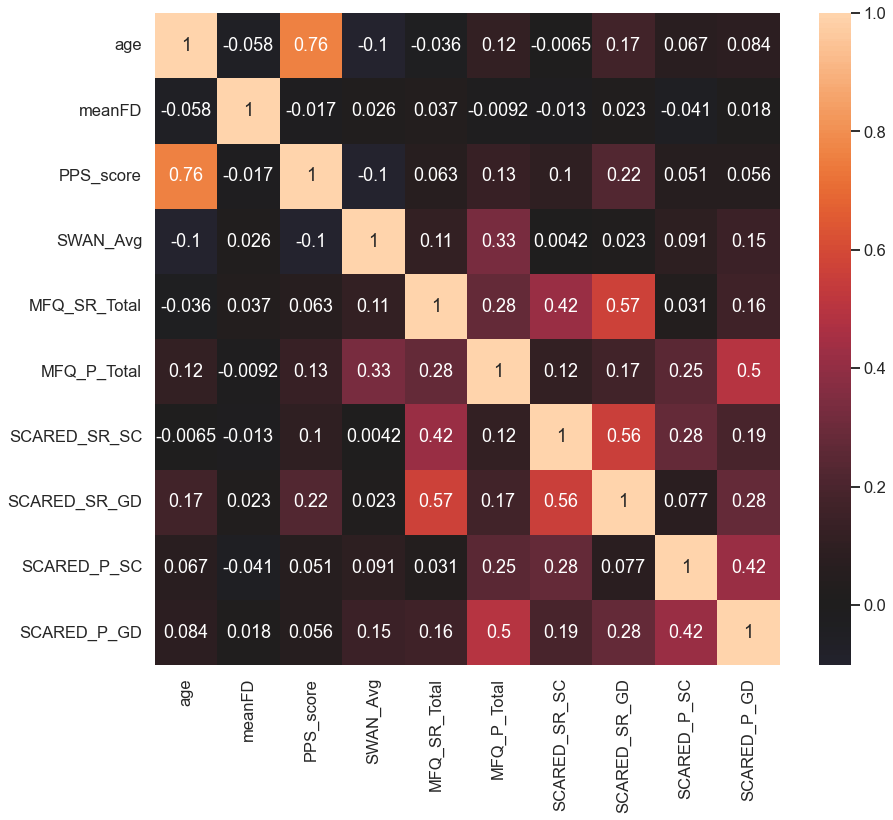

In [20]:
corr = subinfo.loc[:,['age', 'meanFD', 'PPS_score','SWAN_Avg', 'MFQ_SR_Total', 'MFQ_P_Total', 
                      'SCARED_SR_SC','SCARED_SR_GD', 'SCARED_P_SC', 'SCARED_P_GD']].corr()

plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True,center=0)

# How is motion associated with activation patterns?

## Run IS-RSA predicting meanFD in each sample

In [ ]:
out_dir = project_dir + 'proc/clin_motion/'
os.makedirs(out_dir,exist_ok=True)

for sample in ['rubic','cbic']:
    for movie in ['TP','DM']:
        sampleinfo = subinfo.loc[(subinfo['site']==sample) & (subinfo['movie']==movie),:]
        sampleinfo.loc[:,['age','meanFD']] = StandardScaler().fit_transform(sampleinfo.loc[:,['age', 'meanFD']])
        res = smf.ols('meanFD ~ age + female', data=sampleinfo).fit()
        sampleinfo['meanFD'] = res.resid.to_frame().iloc[:,0]

        print(movie, sample, 'N =', len(sampleinfo))
        outdir = os.path.join(out_dir, 'agegroup_similarity_regagesex', 'all', 
                              'ts_isc_{0}_movie{1}'.format(sample, movie))
        os.makedirs(outdir, exist_ok=True)
        group_data_file = os.path.join(outdir, 'compiled_timeseries_data_{0}_movie{1}.npy'.format(sample, movie))
        if os.path.isfile(group_data_file):
            group_data = np.load(group_data_file)
        else:
            group_data = compile_ts_data(sampleinfo, movie, data_dir, group_data_file)

        outprefix = os.path.join(outdir, '{0}_movie{1}_'.format(sample, movie))
        if os.path.isfile(outprefix + 'intersub_timeseries_ISC.npy'):
            regional_sim_data = np.load(outprefix + 'intersub_timeseries_ISC.npy')
        else:
            regional_sim_data, mean_isc = intersubject_timeseries_correlation(group_data, outprefix)

        outfile_prefix = os.path.join(outdir, '{0}_movie{1}_motion_similarity'.format(sample, movie))
        isdistances = intersubject_distance(sampleinfo['meanFD'].to_numpy(), outfile_prefix)

        for sim in ['NN', 'AnnaKmin', 'AnnaKmaxminmax']:
            print(sim)
            outprefix = os.path.join(outdir, '{0}_movie{1}_{2}_motion_similarity'.format(sample, movie, sim))
            bx_sim_data = isdistances[sim]
            if not os.path.isfile(outprefix + '_permsim_raw_rho.pscalar.nii'):
                isc_rho = regional_perm_bx_isrsa(regional_sim_data, bx_sim_data, outprefix)       

for movie in ['DM','TP']:
    analysis_outdir = os.path.join(out_dir, 'agegroup_similarity_regagesex', 'all', 'ts_isc_movie{0}'.format(movie))
    os.makedirs(analysis_outdir, exist_ok=True)

    for sim in ['AnnaKmaxminmax','NN','AnnaKmin']:
        print(sim)
        disc_pval = os.path.join(out_dir, 'agegroup_similarity_regagesex','all','ts_isc_rubic_movie{0}'.format(movie),
                                 'rubic_movie{0}_{1}_motion_similarity_permsim_raw_pval.pscalar.nii'.format(movie, sim))
        disc_rho = os.path.join(out_dir,'agegroup_similarity_regagesex', 'all','ts_isc_rubic_movie{0}'.format(movie),
                                'rubic_movie{0}_{1}_motion_similarity_permsim_raw_rho.pscalar.nii'.format(movie, sim))
        rep_pval = os.path.join(out_dir,'agegroup_similarity_regagesex', 'all','ts_isc_cbic_movie{0}'.format(movie),
                                'cbic_movie{0}_{1}_motion_similarity_permsim_raw_pval.pscalar.nii'.format(movie, sim))
        rep_rho = os.path.join(out_dir, 'agegroup_similarity_regagesex','all','ts_isc_cbic_movie{0}'.format(movie),
                               'cbic_movie{0}_{1}_motion_similarity_permsim_raw_rho.pscalar.nii'.format(movie, sim))

        outprefix = os.path.join(analysis_outdir, 'movie{0}_isc_{1}'.format(movie, sim))
        region_isrsa_fdr(disc_rho, disc_pval, rep_rho, rep_pval, outprefix)

In [40]:
analysis_outdir = os.path.join(out_dir, 'agegroup_similarity_regagesex', 'all')

# find regions with simliarity associated with motion across movies
DM_rhos = nib.load(os.path.join(analysis_outdir, 'ts_isc_movieDM','movieDM_isc_AnnaKmaxminmax_maskedrho_fdr0.01127.pscalar.nii')).get_fdata()
TP_rhos = nib.load(os.path.join(analysis_outdir, 'ts_isc_movieTP','movieTP_isc_AnnaKmaxminmax_maskedrho_fdr0.01127.pscalar.nii')).get_fdata()

mask = (DM_rhos>0) & (TP_rhos>0)
DM_rhos[mask==0] = np.nan
TP_rhos[mask==0] = np.nan
avg_rho = (DM_rhos + TP_rhos)/2

ax0 = nib.load(os.path.join(analysis_outdir, 'ts_isc_movieDM','movieDM_isc_AnnaKmaxminmax_maskedrho_fdr0.01127.pscalar.nii')).header.get_axis(0)
ax1 = nib.load(os.path.join(analysis_outdir, 'ts_isc_movieDM','movieDM_isc_AnnaKmaxminmax_maskedrho_fdr0.01127.pscalar.nii')).header.get_axis(1)

img = nib.cifti2.cifti2.Cifti2Image(avg_rho, (ax0, ax1))
nib.save(img, os.path.join(analysis_outdir, 'ts_isc_bothmovies','bothmovies_isc_AnnaKmaxminmax_maskedrho_fdr0.01127.pscalar.nii'))

In [47]:
# quantify regions with motion associations
orig_outdir = out_dir = project_dir + 'proc/clin/agegroup_similarity_regagesxs/all'
net_df = pd.DataFrame()
included_labels = network_labels[np.squeeze(avg_rho)>0]
DM_p = nib.load(os.path.join(orig_outdir,'ts_isc_movieDM_SCARED_P_SC',
                             'movieDM_isc_SCARED_P_SC_AnnaKmaxminmax_maskedrho_fdr0.01127.pscalar.nii')).get_fdata()>0
DM_p_m = DM_p & (np.squeeze(avg_rho)>0)
DM_sr = nib.load(os.path.join(orig_outdir,'ts_isc_movieDM_SCARED_SR_SC',
                             'movieDM_isc_SCARED_SR_SC_AnnaKmaxminmax_maskedrho_fdr0.01127.pscalar.nii')).get_fdata()>0
DM_sr_m = DM_sr & (np.squeeze(avg_rho)>0)
TP_p = nib.load(os.path.join(orig_outdir,'ts_isc_movieTP_SCARED_P_SC',
                             'movieTP_isc_SCARED_P_SC_AnnaKmaxminmax_maskedrho_fdr0.01127.pscalar.nii')).get_fdata()>0 
TP_p_m = TP_p & (np.squeeze(avg_rho)>0)
TP_sr = nib.load(os.path.join(orig_outdir,'ts_isc_movieTP_SCARED_SR_SC',
                             'movieTP_isc_SCARED_SR_SC_AnnaKmaxminmax_maskedrho_fdr0.01127.pscalar.nii')).get_fdata()>0 
TP_sr_m = TP_sr & (np.squeeze(avg_rho)>0)

for net in network_names:
    net_df.loc[net,'N'] = np.sum(included_labels==net)
    net_df.loc[net,'N_percent'] = net_df.loc[net,'N']/np.sum(network_labels==net)
    net_df.loc[net,'N_overlapDM_PSC'] = np.sum(DM_p_m & (network_labels==net))/np.sum((DM_p & (network_labels==net)))
    net_df.loc[net,'N_overlapDM_SRSC'] = np.sum(DM_sr_m & (network_labels==net))/np.sum((DM_sr & (network_labels==net)))
    net_df.loc[net,'N_overlapTP_PSC'] = np.sum(TP_p_m & (network_labels==net))/np.sum((TP_p & (network_labels==net)))
    net_df.loc[net,'N_overlapTP_SRSC'] = np.sum(TP_sr_m & (network_labels==net))/np.sum((TP_sr & (network_labels==net)))
net_df

,N,N_percent,N_overlapDM_PSC,N_overlapDM_SRSC,N_overlapTP_PSC,N_overlapTP_SRSC
Accumbens,0.0,0.000000,NaN,NaN,NaN,NaN
Amygdala,0.0,0.000000,NaN,NaN,NaN,NaN
Auditory,18.0,0.750000,0.571429,0.500000,0.666667,1.0
Caudate,0.0,0.000000,NaN,NaN,NaN,NaN
Cerebellum,8.0,0.296296,0.000000,0.333333,0.000000,NaN
CinguloOperc,19.0,0.475000,0.714286,0.857143,0.727273,0.6
Default,19.0,0.463415,0.600000,0.666667,1.000000,NaN
DorsalAttn,22.0,0.687500,0.800000,0.866667,0.833333,0.5
FrontoParietal,10.0,0.416667,0.400000,0.500000,0.666667,1.0
Hippocampus,0.0,0.000000,NaN,NaN,NaN,NaN


In [ ]:
for clin in ['SCARED_P_SC', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_GD','SCARED_P_SP', 'SCARED_SR_SP']:
    if 'SR' in clin:
        other = 'MFQ_SR_Total'
    else:
        other = 'MFQ_P_Total'
    for sample in ['rubic','cbic']:
        for movie in ['TP','DM']:
            sampleinfo = subinfo.loc[(subinfo['site']==sample) & (subinfo['movie']==movie) & np.isfinite(subinfo[clin]),:]
            sampleinfo.loc[:,['age','meanFD', clin, other, 'SWAN_Avg']] = StandardScaler().fit_transform(sampleinfo.loc[:,['age', 'meanFD', clin, other, 'SWAN_Avg']])
            sampleinfo.loc[:,['age', 'female', 'meanFD', clin, other,'SWAN_Avg']] = \
            IterativeImputer(random_state=42).fit_transform(sampleinfo.loc[:,['age', 'female', 'meanFD', clin, other,'SWAN_Avg']].to_numpy())
            res = smf.ols('{0} ~ age + female + meanFD + {1} + SWAN_Avg'.format(clin, other), data=sampleinfo).fit()
            sampleinfo[clin] = res.resid.to_frame().iloc[:,0]

            print(clin, movie, sample, 'N =', len(sampleinfo))
            outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd', 'all', 
                                  'ts_isc_{0}_movie{1}_{2}'.format(sample, movie, clin))
            os.makedirs(outdir, exist_ok=True)
            group_data_file = os.path.join(outdir, 'compiled_timeseries_data_{0}_movie{1}.npy'.format(sample, movie))
            if os.path.isfile(group_data_file):
                group_data = np.load(group_data_file)
            else:
                group_data = compile_ts_data(sampleinfo, movie, data_dir, group_data_file)

            outprefix = os.path.join(outdir, '{0}_movie{1}_'.format(sample, movie))
            if os.path.isfile(outprefix + 'intersub_timeseries_ISC.npy'):
                regional_sim_data = np.load(outprefix + 'intersub_timeseries_ISC.npy')
            else:
                regional_sim_data, mean_isc = intersubject_timeseries_correlation(group_data, outprefix)

            outfile_prefix = os.path.join(outdir, '{0}_movie{1}_{2}_similarity'.format(sample, movie, clin))
            isdistances = intersubject_distance(sampleinfo[clin].to_numpy(), outfile_prefix)

            for sim in ['NN', 'AnnaKmin', 'AnnaKmaxminmax']:
                outprefix = os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity'.format(sample, movie, clin, sim))
                bx_sim_data = isdistances[sim]
                if not os.path.isfile(outprefix + '_permsim_raw_rho.pscalar.nii'):
                    isc_rho = regional_perm_bx_isrsa(regional_sim_data, bx_sim_data, outprefix)
                    

for clin in ['SCARED_P_SC', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_GD','SCARED_P_SP', 'SCARED_SR_SP']:
    for movie in ['DM','TP']:
        analysis_outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd', 'all', 'ts_isc_movie{0}_{1}'.format(movie, clin))
        os.makedirs(analysis_outdir, exist_ok=True)

        for sim in ['AnnaKmaxminmax','NN','AnnaKmin']:
            disc_pval = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd','all','ts_isc_rubic_movie{0}_{1}'.format(movie, clin),
                                     'rubic_movie{0}_{1}_{2}_similarity_permsim_raw_pval.pscalar.nii'.format(movie, clin, sim))
            disc_rho = os.path.join(out_dir,'agegroup_similarity_regagesxsadhd', 'all','ts_isc_rubic_movie{0}_{1}'.format(movie, clin),
                                    'rubic_movie{0}_{1}_{2}_similarity_permsim_raw_rho.pscalar.nii'.format(movie, clin, sim))
            rep_pval = os.path.join(out_dir,'agegroup_similarity_regagesxsadhd', 'all','ts_isc_cbic_movie{0}_{1}'.format(movie, clin),
                                    'cbic_movie{0}_{1}_{2}_similarity_permsim_raw_pval.pscalar.nii'.format(movie, clin, sim))
            rep_rho = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd','all','ts_isc_cbic_movie{0}_{1}'.format(movie, clin),
                                   'cbic_movie{0}_{1}_{2}_similarity_permsim_raw_rho.pscalar.nii'.format(movie, clin, sim))

            outprefix = os.path.join(analysis_outdir, 'movie{0}_isc_{1}_{2}'.format(movie, clin, sim))
            region_isrsa_fdr(disc_rho, disc_pval, rep_rho, rep_pval, outprefix)

In [ ]:
niters = int(10000/len(parcel_labels))

#for clin in ['SCARED_P_SC', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_GD']:
for clin in ['SCARED_P_SP', 'SCARED_SR_SP']:
    for sample in ['rubic','cbic']:
        for movie in ['TP','DM']:
            print(sample, movie, clin)
            outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd', 'all', 
                                  'ts_isc_{0}_movie{1}_{2}'.format(sample, movie, clin))

            outprefix = os.path.join(outdir, '{0}_movie{1}_'.format(sample, movie))
            if os.path.isfile(outprefix + 'intersub_timeseries_ISC.npy'):
                regional_sim_data = np.load(outprefix + 'intersub_timeseries_ISC.npy')
            else:
                regional_sim_data, mean_isc = intersubject_timeseries_correlation(group_data, outprefix)

            for sim in ['NN', 'AnnaKmin', 'AnnaKmaxminmax']:
                print(sample, movie, sim, clin)
                sig = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_pval.pscalar.nii'.format(sample, movie, clin, sim))).get_fdata()
                rho = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_rho.pscalar.nii'.format(sample, movie, clin, sim))).get_fdata()
                sigrho = rho
                sigrho[sig>0.05] = 0
                sim_filename = os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}.npy'.format(sample, movie, clin, sim))
                simdist_filename = os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}_bootdist.npy'.format(sample, movie, clin, sim))
                bx_sim_data = np.load(sim_filename)

                rhodist = np.zeros((niters, regional_sim_data.shape[0]))
                for parc in range(0,regional_sim_data.shape[0]):
                    parcsim = regional_sim_data[parc,:,:]
                    if sigrho[0,parc]>0:
                        for i in range(0,niters):
                            bootsample_size = np.random.randint(int(regional_sim_data.shape[1]*0.5),int(regional_sim_data.shape[1]*0.75))
                            subsampmask = np.full(regional_sim_data.shape[1], 0)
                            subsampmask[:bootsample_size] = 1
                            np.random.shuffle(subsampmask)
                            subsamp_bx = bx_sim_data[subsampmask==1, :][:, subsampmask==1]
                            subsamp_brain = parcsim[subsampmask==1, :][:, subsampmask==1]
                            res = static_brain_bx_isrsa(subsamp_brain, subsamp_bx)
                            rhodist[i,parc] = res.loc[0,'SpearR']
                np.save(simdist_filename, rhodist)

In [ ]:
alpha = np.sqrt(0.05/len(parcel_labels))
ciftkey = {0: {'label':'None', 'cifticolor':(1, 1, 1, 0), 'plotcolor':'#3893f5'}, # clear
           1: {'label':'NN', 'cifticolor':(56/255, 147/255, 245/255, 1), 'plotcolor':'#3893f5'}, # blue
           2: {'label':'AnnaKmin', 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
           3: {'label':'AnnaKmaxminmax', 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}, # gold
           12: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
           21: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
           13: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
           31: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
           23: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'}, # green
           32: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'},
           123: {'label':'All', 'cifticolor':(255/255, 255/255, 255/255, 1), 'plotcolor': '#029c0c'}} # white

#for clin in ['SCARED_P_SC', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_GD']:
for clin in ['SCARED_P_SP', 'SCARED_SR_SP']:
    for sample in ['rubic','cbic']:
        for movie in ['TP','DM']:
            # per parcel, rank point estimates and identify best fitting model
            fitkey = {'NN': {'value':1, 'cifticolor':(56/255, 147/255, 245/255, 1), 'plotcolor':'#3893f5'}, # blue
                      'AnnaKmin': {'value':2, 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
                      'AnnaKmaxminmax': {'value':3, 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}} # gold
            sims = list(fitkey.keys())

            print(sample, movie, clin)
            outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd', 'all', 'ts_isc_{0}_movie{1}_{2}'.format(sample, movie, clin))

            # load point estimates for each model of development
            pointests = []
            pointestsps = []
            distributions = []
            for est in sims:
                point = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_rho.pscalar.nii'.format(sample, movie, clin, est))).get_fdata()
                pointests.append(point)
                pointps = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_pval.pscalar.nii'.format(sample, movie, clin, est))).get_fdata()
                pointestsps.append(pointps)
                dist = np.load(os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}_bootdist.npy'.format(sample, movie, clin, est)))
                distributions.append(np.expand_dims(dist, axis=2))
            distributions = np.concatenate(distributions, axis=2)
            pointests = np.concatenate(pointests, axis=0)
            pointestsps = np.concatenate(pointestsps, axis=0)

            pointests_binarized = np.zeros_like(pointests)
            pointests_binarized[(pointests>0) & (pointestsps<alpha)] = 1
            sigpointestssum = np.sum(pointests_binarized, axis=0).astype(int)

            rankorder = np.zeros((len(sims), pointests.shape[1]))

            for parc in range(0, sigpointestssum.shape[0]):
                parc_bin = pointests_binarized[:,parc]
                if sigpointestssum[parc]==1:
                    rankorder[0,parc] = np.where(parc_bin==1)[0][0] + 1
                elif sigpointestssum[parc]==2:
                    models = np.where(parc_bin==1)[0]
                    t, p = scp.stats.ttest_rel(distributions[:, parc,models[0]],distributions[:, parc,models[1]])
                    if p<0.05:
                        if pointests[models[0], parc] > pointests[models[1], parc]:
                            rankorder[0,parc] = models[0] + 1
                            rankorder[1,parc] = models[1] + 1
                        else:
                            rankorder[0,parc] = models[1] + 1
                            rankorder[1,parc] = models[0] + 1
                    else:
                        rankorder[0,parc] = int('{0}{1}'.format(models[0],models[1]))
                elif sigpointestssum[parc]==3:
                    tpoint = pointests[:,parc]
                    rank = np.argsort(tpoint)
                    t, p = scp.stats.ttest_rel(distributions[:,parc,rank[0]],distributions[:, parc,rank[1]])
                    if p<0.05:
                        rankorder[0,parc] = rank[0] + 1
                        # test second versus third place
                        t, p = scp.stats.ttest_ind(distributions[:,parc,rank[1]],distributions[:, parc,rank[2]])
                        if p<0.05:
                            rankorder[1,parc] = rank[1] + 1
                            rankorder[2,parc] = rank[2] + 1
                        else:
                            rankorder[1,parc] = int('{0}{1}'.format(rank[1],rank[2]))
                    else:
                        t, p = scp.stats.ttest_rel(distributions[:, parc,rank[0]],distributions[:, parc,rank[2]])
                        if p<0.05:
                            rankorder[0,parc] = int('{0}{1}'.format(models[0],models[1]))
                            rankorder[1,parc] = rank[2] + 1
                        else:
                            rankorder[0,parc] = 123
            np.save(os.path.join(outdir, 'model_rank_orders.npy'), rankorder)

            # make cifti label file with best model fit
            ax1 = nib.load(atlas_file).header.get_axis(1)
            data = nib.load(atlas_file).get_fdata()
            ax0 = nib.load(atlas_file).header.get_axis(0)
            newmap=dict()
            newmap[0] = ax0[0][1][0]
            for a in range(0,len(parcel_labels)):
                newmap[a+1] = (ciftkey[rankorder[0,a]]['label'] + '_n{0}'.format(a), ciftkey[rankorder[0,a]]['cifticolor'])
            ax0.label[0] = newmap
            img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
            nib.save(img, os.path.join(outdir, 'top_model_fits.dlabel.nii'))

In [ ]:
#for clin in ['SCARED_P_SC', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_GD']:
for clin in ['SCARED_P_SP', 'SCARED_SR_SP']:
    # find consistent patterns across discovery and replication samples
    for movie in ['TP','DM']:
        disc_fits = np.load(os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd','all', 'ts_isc_rubic_movie{0}_{1}'.format(movie, clin), 'model_rank_orders.npy'))
        rep_fits = np.load(os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd','all', 'ts_isc_cbic_movie{0}_{1}'.format(movie, clin), 'model_rank_orders.npy'))

        outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd','all', 'ts_isc_movie{0}_{1}'.format(movie, clin))

        ### make a cifti with the outputs
        # make label file with best model fit
        mask = np.zeros((disc_fits.shape[1]))
        mask[(disc_fits[0]==rep_fits[0])]=1

        both_fits = disc_fits[0]
        both_fits[mask==0] = 0
        np.save(os.path.join(outdir,'replicable_top_models.npy'), both_fits)

        ax1 = nib.load(atlas_file).header.get_axis(1)
        data = nib.load(atlas_file).get_fdata()
        ax0 = nib.load(atlas_file).header.get_axis(0)
        newmap=dict()
        newmap[0] = ax0[0][1][0]
        for a in range(0,len(parcel_labels)):
            newmap[a+1] = (ciftkey[both_fits[a]]['label'] + '_n{0}'.format(a), ciftkey[both_fits[a]]['cifticolor'])
        ax0.label[0] = newmap
        img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
        nib.save(img, os.path.join(outdir, 'top_model_fits_replicable.dlabel.nii'))
        
    # find consistent patterns across both movies
    outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd','all', 'ts_isc_bothmovies_{0}'.format(clin))
    os.makedirs(outdir, exist_ok=True)

    DM = np.load(os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd','all', 'ts_isc_movieDM_{0}'.format(clin),'replicable_top_models.npy'))
    TP = np.load(os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd','all', 'ts_isc_movieTP_{0}'.format(clin),'replicable_top_models.npy'))

    mask = np.zeros((DM.shape[0]))
    mask[(DM==TP)]=1

    both_fits = DM
    both_fits[mask==0] = 0

    np.save(os.path.join(outdir,'samebothvideos_top_models.npy'), both_fits)
    ax1 = nib.load(atlas_file).header.get_axis(1)
    data = nib.load(atlas_file).get_fdata()
    ax0 = nib.load(atlas_file).header.get_axis(0)
    newmap=dict()
    newmap[0] = ax0[0][1][0]
    for a in range(0,len(parcel_labels)):
        newmap[a+1] = (ciftkey[both_fits[a]]['label'] + '_n{0}'.format(a), ciftkey[both_fits[a]]['cifticolor'])
    ax0.label[0] = newmap
    img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
    nib.save(img, os.path.join(outdir, 'top_model_fits_replicable_bothmovies.dlabel.nii'))

## IS-RSA for each age group

In [ ]:
groups = np.unique(subinfo['age_group'])

for age in groups:
    agesubinfo = subinfo.loc[subinfo['age_group']==age,:]
    if age=='younger':  
        clins = ['SCARED_P_SC','SCARED_P_GD','SCARED_P_SP']
    else:
        clins = ['SCARED_P_SC', 'SCARED_P_GD','SCARED_P_SP', 'SCARED_SR_SC','SCARED_SR_GD', 'SCARED_SR_SP']

    for clin in clins:
        if 'SR' in clin:
            other = 'MFQ_SR_Total'
        else:
            other = 'MFQ_P_Total'
        for sample in ['rubic','cbic']:
            for movie in ['TP','DM']:
                sampleinfo = agesubinfo.loc[(agesubinfo['site']==sample) & (agesubinfo['movie']==movie) & np.isfinite(agesubinfo[clin]),:]
                sampleinfo.loc[:,['age','meanFD', clin, other, 'SWAN_Avg']] = StandardScaler().fit_transform(sampleinfo.loc[:,['age', 'meanFD', clin, other, 'SWAN_Avg']])
                sampleinfo.loc[:,['age', 'female', 'meanFD', clin, other, 'SWAN_Avg']] = \
                IterativeImputer(random_state=42).fit_transform(sampleinfo.loc[:,['age', 'female', 'meanFD', clin, other, 'SWAN_Avg']])
                res = smf.ols('{0} ~ age + female + meanFD + {1} + SWAN_Avg'.format(clin, other), data=sampleinfo).fit()
                sampleinfo[clin] = res.resid.to_frame().iloc[:,0]
                
                print(age, clin, movie, sample, 'N =', len(sampleinfo))
                outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd', age, 
                                      'ts_isc_{0}_movie{1}_{2}'.format(sample, movie, clin))
                os.makedirs(outdir, exist_ok=True)
                group_data_file = os.path.join(outdir, 'compiled_timeseries_data_{0}_movie{1}.npy'.format(sample, movie))
                if os.path.isfile(group_data_file):
                    group_data = np.load(group_data_file)
                else:
                    group_data = compile_ts_data(sampleinfo, movie, data_dir, group_data_file)

                outprefix = os.path.join(outdir, '{0}_movie{1}_'.format(sample, movie))
                if os.path.isfile(outprefix + 'intersub_timeseries_ISC.npy'):
                    regional_sim_data = np.load(outprefix + 'intersub_timeseries_ISC.npy')
                else:
                    regional_sim_data, mean_isc = intersubject_timeseries_correlation(group_data, outprefix)

                outfile_prefix = os.path.join(outdir, '{0}_movie{1}_{2}_similarity'.format(sample, movie, clin))
                isdistances = intersubject_distance(sampleinfo[clin].to_numpy(), outfile_prefix)

                for sim in ['NN', 'AnnaKmin', 'AnnaKmaxminmax']:
                    outprefix = os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity'.format(sample, movie, clin, sim))
                    bx_sim_data = isdistances[sim]
                    if not os.path.isfile(outprefix + '_permsim_raw_rho.pscalar.nii'):
                        isc_rho = regional_perm_bx_isrsa(regional_sim_data, bx_sim_data, outprefix)
                        
        for movie in ['DM','TP']:
            analysis_outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd', age, 'ts_isc_movie{0}_{1}'.format(movie, clin))
            os.makedirs(analysis_outdir, exist_ok=True)

            for sim in ['AnnaKmaxminmax','NN','AnnaKmin']:
                disc_pval = os.path.join(out_dir, 'agegroup_similarity_regagesxs',age,'ts_isc_rubic_movie{0}_{1}'.format(movie, clin),
                                         'rubic_movie{0}_{1}_{2}_similarity_permsim_raw_pval.pscalar.nii'.format(movie, clin, sim))
                disc_rho = os.path.join(out_dir,'agegroup_similarity_regagesxs', age,'ts_isc_rubic_movie{0}_{1}'.format(movie, clin),
                                        'rubic_movie{0}_{1}_{2}_similarity_permsim_raw_rho.pscalar.nii'.format(movie, clin, sim))
                rep_pval = os.path.join(out_dir,'agegroup_similarity_regagesxs', age,'ts_isc_cbic_movie{0}_{1}'.format(movie, clin),
                                        'cbic_movie{0}_{1}_{2}_similarity_permsim_raw_pval.pscalar.nii'.format(movie, clin, sim))
                rep_rho = os.path.join(out_dir, 'agegroup_similarity_regagesxs',age,'ts_isc_cbic_movie{0}_{1}'.format(movie, clin),
                                       'cbic_movie{0}_{1}_{2}_similarity_permsim_raw_rho.pscalar.nii'.format(movie, clin, sim))

                outprefix = os.path.join(analysis_outdir, 'movie{0}_isc_{1}_{2}'.format(movie, clin, sim))
                region_isrsa_fdr(disc_rho, disc_pval, rep_rho, rep_pval, outprefix)

In [ ]:
niters = int(10000/len(parcel_labels))

for age in groups:
    for clin in ['SCARED_P_SC', 'SCARED_SR_GD','SCARED_P_SP', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_SP']:
        if os.path.isdir(os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd',age,'ts_isc_rubic_movie{0}_{1}'.format(movie, clin))):
            for sample in ['rubic','cbic']:
                for movie in ['TP','DM']:
                    print(sample, movie, clin)
                    outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd', age, 
                                          'ts_isc_{0}_movie{1}_{2}'.format(sample, movie, clin))

                    outprefix = os.path.join(outdir, '{0}_movie{1}_'.format(sample, movie))
                    if os.path.isfile(outprefix + 'intersub_timeseries_ISC.npy'):
                        regional_sim_data = np.load(outprefix + 'intersub_timeseries_ISC.npy')
                    else:
                        regional_sim_data, mean_isc = intersubject_timeseries_correlation(group_data, outprefix)

                    for sim in ['NN', 'AnnaKmin', 'AnnaKmaxminmax']:
                        print(sample, movie, sim, clin)
                        sig = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_pval.pscalar.nii'.format(sample, movie, clin, sim))).get_fdata()
                        rho = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_rho.pscalar.nii'.format(sample, movie, clin, sim))).get_fdata()
                        sigrho = rho
                        sigrho[sig>0.05] = 0
                        sim_filename = os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}.npy'.format(sample, movie, clin, sim))
                        simdist_filename = os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}_bootdist.npy'.format(sample, movie, clin, sim))
                        bx_sim_data = np.load(sim_filename)

                        rhodist = np.zeros((niters, regional_sim_data.shape[0]))
                        for parc in range(0,regional_sim_data.shape[0]):
                            parcsim = regional_sim_data[parc,:,:]
                            if sigrho[0,parc]>0:
                                for i in range(0,niters):
                                    bootsample_size = np.random.randint(int(regional_sim_data.shape[1]*0.5),int(regional_sim_data.shape[1]*0.75))
                                    subsampmask = np.full(regional_sim_data.shape[1], 0)
                                    subsampmask[:bootsample_size] = 1
                                    np.random.shuffle(subsampmask)
                                    subsamp_bx = bx_sim_data[subsampmask==1, :][:, subsampmask==1]
                                    subsamp_brain = parcsim[subsampmask==1, :][:, subsampmask==1]
                                    res = static_brain_bx_isrsa(subsamp_brain, subsamp_bx)
                                    rhodist[i,parc] = res.loc[0,'SpearR']
                        np.save(simdist_filename, rhodist)

In [ ]:
alpha = np.sqrt(0.05/len(parcel_labels))
ciftkey = {0: {'label':'None', 'cifticolor':(1, 1, 1, 0), 'plotcolor':'#3893f5'}, # clear
           1: {'label':'NN', 'cifticolor':(56/255, 147/255, 245/255, 1), 'plotcolor':'#3893f5'}, # blue
           2: {'label':'AnnaKmin', 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
           3: {'label':'AnnaKmaxminmax', 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}, # gold
           12: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
           21: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
           13: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
           31: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
           23: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'}, # green
           32: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'},
           123: {'label':'All', 'cifticolor':(255/255, 255/255, 255/255, 1), 'plotcolor': '#029c0c'}} # white

for age in groups:
    for clin in ['SCARED_P_SC', 'SCARED_SR_GD','SCARED_P_SP', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_SP']:
        if os.path.isdir(os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd',age,'ts_isc_rubic_movie{0}_{1}'.format(movie, clin))):
            for sample in ['rubic','cbic']:
                for movie in ['TP','DM']:
                    # per parcel, rank point estimates and identify best fitting model
                    fitkey = {'NN': {'value':1, 'cifticolor':(56/255, 147/255, 245/255, 1), 'plotcolor':'#3893f5'}, # blue
                              'AnnaKmin': {'value':2, 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
                              'AnnaKmaxminmax': {'value':3, 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}} # gold
                    sims = list(fitkey.keys())

                    print(sample, movie, clin)
                    outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd', age, 'ts_isc_{0}_movie{1}_{2}'.format(sample, movie, clin))

                    # load point estimates for each model of development
                    pointests = []
                    pointestsps = []
                    distributions = []
                    for est in sims:
                        point = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_rho.pscalar.nii'.format(sample, movie, clin, est))).get_fdata()
                        pointests.append(point)
                        pointps = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_pval.pscalar.nii'.format(sample, movie, clin, est))).get_fdata()
                        pointestsps.append(pointps)
                        dist = np.load(os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}_bootdist.npy'.format(sample, movie, clin, est)))
                        distributions.append(np.expand_dims(dist, axis=2))
                    distributions = np.concatenate(distributions, axis=2)
                    pointests = np.concatenate(pointests, axis=0)
                    pointestsps = np.concatenate(pointestsps, axis=0)

                    pointests_binarized = np.zeros_like(pointests)
                    pointests_binarized[(pointests>0) & (pointestsps<alpha)] = 1
                    sigpointestssum = np.sum(pointests_binarized, axis=0).astype(int)

                    rankorder = np.zeros((len(sims), pointests.shape[1]))

                    for parc in range(0, sigpointestssum.shape[0]):
                        parc_bin = pointests_binarized[:,parc]
                        if sigpointestssum[parc]==1:
                            rankorder[0,parc] = np.where(parc_bin==1)[0][0] + 1
                        elif sigpointestssum[parc]==2:
                            models = np.where(parc_bin==1)[0]
                            t, p = scp.stats.ttest_rel(distributions[:, parc,models[0]],distributions[:, parc,models[1]])
                            if p<0.05:
                                if pointests[models[0], parc] > pointests[models[1], parc]:
                                    rankorder[0,parc] = models[0] + 1
                                    rankorder[1,parc] = models[1] + 1
                                else:
                                    rankorder[0,parc] = models[1] + 1
                                    rankorder[1,parc] = models[0] + 1
                            else:
                                rankorder[0,parc] = int('{0}{1}'.format(models[0],models[1]))
                        elif sigpointestssum[parc]==3:
                            tpoint = pointests[:,parc]
                            rank = np.argsort(tpoint)
                            t, p = scp.stats.ttest_rel(distributions[:,parc,rank[0]],distributions[:, parc,rank[1]])
                            if p<0.05:
                                rankorder[0,parc] = rank[0] + 1
                                # test second versus third place
                                t, p = scp.stats.ttest_ind(distributions[:,parc,rank[1]],distributions[:, parc,rank[2]])
                                if p<0.05:
                                    rankorder[1,parc] = rank[1] + 1
                                    rankorder[2,parc] = rank[2] + 1
                                else:
                                    rankorder[1,parc] = int('{0}{1}'.format(rank[1],rank[2]))
                            else:
                                t, p = scp.stats.ttest_rel(distributions[:, parc,rank[0]],distributions[:, parc,rank[2]])
                                if p<0.05:
                                    rankorder[0,parc] = int('{0}{1}'.format(models[0],models[1]))
                                    rankorder[1,parc] = rank[2] + 1
                                else:
                                    rankorder[0,parc] = 123
                    np.save(os.path.join(outdir, 'model_rank_orders.npy'), rankorder)

                    # make cifti label file with best model fit
                    ax1 = nib.load(atlas_file).header.get_axis(1)
                    data = nib.load(atlas_file).get_fdata()
                    ax0 = nib.load(atlas_file).header.get_axis(0)
                    newmap=dict()
                    newmap[0] = ax0[0][1][0]
                    for a in range(0,len(parcel_labels)):
                        newmap[a+1] = (ciftkey[rankorder[0,a]]['label'] + '_n{0}'.format(a), ciftkey[rankorder[0,a]]['cifticolor'])
                    ax0.label[0] = newmap
                    img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
                    nib.save(img, os.path.join(outdir, 'top_model_fits.dlabel.nii'))

In [ ]:
for age in groups:
    for clin in ['SCARED_P_SC', 'SCARED_SR_GD','SCARED_P_SP', 'SCARED_SR_SC','SCARED_P_GD', 'SCARED_SR_SP']:
        if os.path.isdir(os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd',age,'ts_isc_rubic_movie{0}_{1}'.format(movie, clin))):
            # find consistent patterns across discovery and replication samples
            for movie in ['TP','DM']:
                disc_fits = np.load(os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd',age, 'ts_isc_rubic_movie{0}_{1}'.format(movie, clin), 'model_rank_orders.npy'))
                rep_fits = np.load(os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd',age, 'ts_isc_cbic_movie{0}_{1}'.format(movie, clin), 'model_rank_orders.npy'))

                outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd',age, 'ts_isc_movie{0}_{1}'.format(movie, clin))

                ### make a cifti with the outputs
                # make label file with best model fit
                mask = np.zeros((disc_fits.shape[1]))
                mask[(disc_fits[0]==rep_fits[0])]=1

                both_fits = disc_fits[0]
                both_fits[mask==0] = 0
                np.save(os.path.join(outdir,'replicable_top_models.npy'), both_fits)

                ax1 = nib.load(atlas_file).header.get_axis(1)
                data = nib.load(atlas_file).get_fdata()
                ax0 = nib.load(atlas_file).header.get_axis(0)
                newmap=dict()
                newmap[0] = ax0[0][1][0]
                for a in range(0,len(parcel_labels)):
                    newmap[a+1] = (ciftkey[both_fits[a]]['label'] + '_n{0}'.format(a), ciftkey[both_fits[a]]['cifticolor'])
                ax0.label[0] = newmap
                img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
                nib.save(img, os.path.join(outdir, 'top_model_fits_replicable.dlabel.nii'))
            
            # find consistent patterns across movies
            outdir = os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd', age, 'ts_isc_bothmovies_{0}'.format(clin))
            os.makedirs(outdir, exist_ok=True)

            DM = np.load(os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd', age, 'ts_isc_movieDM_{0}'.format(clin),'replicable_top_models.npy'))
            TP = np.load(os.path.join(out_dir, 'agegroup_similarity_regagesxsadhd', age, 'ts_isc_movieTP_{0}'.format(clin),'replicable_top_models.npy'))

            mask = np.zeros((DM.shape[0]))
            mask[(DM==TP)]=1

            both_fits = DM
            both_fits[mask==0] = 0

            np.save(os.path.join(outdir,'samebothvideos_top_models.npy'), both_fits)
            ax1 = nib.load(atlas_file).header.get_axis(1)
            data = nib.load(atlas_file).get_fdata()
            ax0 = nib.load(atlas_file).header.get_axis(0)
            newmap=dict()
            newmap[0] = ax0[0][1][0]
            for a in range(0,len(parcel_labels)):
                newmap[a+1] = (ciftkey[both_fits[a]]['label'] + '_n{0}'.format(a), ciftkey[both_fits[a]]['cifticolor'])
            ax0.label[0] = newmap
            img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
            nib.save(img, os.path.join(outdir, 'top_model_fits_replicable_bothmovies.dlabel.nii'))